<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/SNS/Colon_cancer_predict_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision timm numpy pillow gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Importamos librerías
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import timm
import os
import zipfile
import gdown
from glob import glob
from shutil import copy2

In [ ]:
# 1️⃣ Descargar archivo ZIP desde Google Drive y extraerlo
url = "https://drive.google.com/uc?id=1P5fh5nKFBW6dnLf4lu8ix9cXA9iMmoKr"
zip_filename = "dataset.zip"
extract_dir = "/content/dataset"

gdown.download(url, zip_filename, quiet=False)
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Verificar contenido extraído
print("Archivos en /content/dataset:", os.listdir(extract_dir))

# Buscar automáticamente la carpeta correcta con imágenes
possible_dirs = [d for d in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, d))]
for subdir in possible_dirs:
    if "colon_aca" in os.listdir(os.path.join(extract_dir, subdir)):
        DATA_DIR = os.path.join(extract_dir, subdir)
        break
else:
    DATA_DIR = extract_dir  # Si no se encuentra, usar el directorio raíz

print("Usando DATA_DIR:", DATA_DIR)
print("Contenido en DATA_DIR:", os.listdir(DATA_DIR))

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")
BATCH_SIZE = 8  # Reducir si hay problemas de memoria
IMG_SIZE = 768
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_RATIO = 0.8  # 80% entrenamiento
VAL_RATIO = 0.1   # 10% validación
TEST_RATIO = 0.1  # 10% prueba

Downloading...
From (original): https://drive.google.com/uc?id=1P5fh5nKFBW6dnLf4lu8ix9cXA9iMmoKr
From (redirected): https://drive.google.com/uc?id=1P5fh5nKFBW6dnLf4lu8ix9cXA9iMmoKr&confirm=t&uuid=9c55d714-9b4f-418c-a20e-45fd46619a91
To: /content/dataset.zip
100%|██████████| 960M/960M [00:23<00:00, 41.1MB/s]


Archivos en /content/dataset: ['colon_aca', 'colon_n']
Usando DATA_DIR: /content/dataset
Contenido en DATA_DIR: ['colon_aca', 'colon_n']


In [ ]:
# Crear carpetas de entrenamiento, validación y prueba si no existen
for folder in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for class_name in ["colon_aca", "colon_n"]:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

# Dividir el dataset en entrenamiento, validación y prueba
for class_name in ["colon_aca", "colon_n"]:
    image_paths = glob(os.path.join(DATA_DIR, class_name, "*.jpeg"))
    if len(image_paths) == 0:
        print(f"⚠️ No se encontraron imágenes en {class_name}. Verifica la estructura del ZIP.")
        continue

    train_size = int(len(image_paths) * TRAIN_RATIO)
    val_size = int(len(image_paths) * VAL_RATIO)

    train_images = image_paths[:train_size]
    val_images = image_paths[train_size:train_size + val_size]
    test_images = image_paths[train_size + val_size:]

    for img in train_images:
        copy2(img, os.path.join(TRAIN_DIR, class_name))
    for img in val_images:
        copy2(img, os.path.join(VAL_DIR, class_name))
    for img in test_images:
        copy2(img, os.path.join(TEST_DIR, class_name))


In [ ]:
# Preprocesamiento de imágenes
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Cargar dataset
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=data_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
# Definir el modelo EfficientNet-B4
model = timm.create_model("efficientnet_b4", pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)  # 2 clases: Benigno / Adenocarcinoma
model = model.to(DEVICE)

# Configuración de entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [ ]:
# Entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/5, Loss: 0.0714
Epoch 2/5, Loss: 0.0026
Epoch 3/5, Loss: 0.0032
Epoch 4/5, Loss: 0.0006
Epoch 5/5, Loss: 0.0002


In [ ]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), "efficientnet_b4_colon.pth")


In [ ]:
# Evaluación del modelo
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_acc = evaluate_model(model, train_loader)
val_acc = evaluate_model(model, val_loader)
test_acc = evaluate_model(model, test_loader)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 1.0000
Validation Accuracy: 1.0000
Test Accuracy: 1.0000


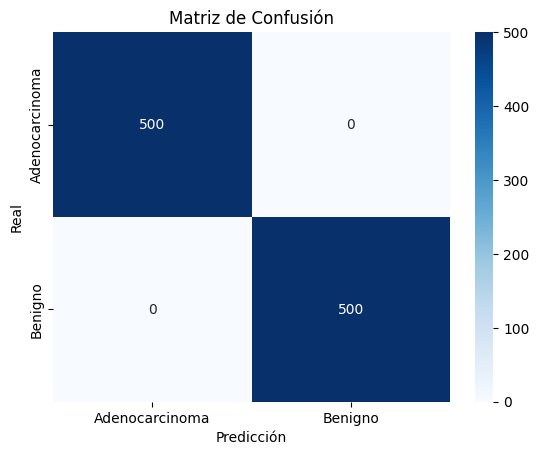

In [ ]:
# Evaluar con una Matriz de Confusión
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Adenocarcinoma", "Benigno"], yticklabels=["Adenocarcinoma", "Benigno"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()

plot_confusion_matrix(model, test_loader)


In [ ]:
# Función para subir y predecir una imagen
from google.colab import files
from PIL import Image

def predict_uploaded_image(model):
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]
    image = Image.open(image_path)

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = transform(image).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_names = ["Adenocarcinoma", "Benigno"]
    print(f"Predicción: {class_names[predicted.item()]}")

# Llamar a la función para subir y predecir una imagen
predict_uploaded_image(model)

Saving colonca10.jpeg to colonca10.jpeg
Predicción: Adenocarcinoma
